## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

**Разработчик: Тимур С.**

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

**Подключение библиотек и скриптов**

In [1]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost
# !pip install imblearn

In [2]:
import numpy as np
import pandas as pd
import pickle
import random
import datetime

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler 

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

d:\Users\Tim\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
d:\Users\Tim\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
now1 = datetime.datetime.now()

**Пути к директориям и файлам**

In [4]:
# input
TRAIN_DATASET_PATH = '../course_project_train.csv'
TEST_DATASET_PATH = '../course_project_test.csv'
TRAIN_FULL_PATH = '../training_project_train_full.csv'
TRAIN_PART_PATH = '../training_project_train_part_b.csv'
TEST_PART_PATH = '../training_project_test_part.csv'

# output
PREP_DATASET_PATH = '../training_project_data_prep.csv'
SCALER_FILE_PATH = '../scaler.pkl'
MODEL_FILE_PATH = '../model.pkl'

## Построение модели классификации

### Обзор обучающего датасета

**Загрузка данных**

In [5]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_base = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [6]:
df_train.shape

(7500, 17)

In [7]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [8]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

В колонках Annual Income, Years in current job, Months since last delinquent, Bankruptcies, Credit Score имеются пропуски.
Их нужно будет некоторым образом обработать.

### Приведение типов

Узнаем, какое количество разнообразных значений содержится в каждом из столбцов.

In [10]:
for colname in df_train.columns:
    print(str(colname) + ' (diversity: ' + str(len(df_train[colname].value_counts())) + ') \n\n' 
          + str(df_train[colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership (diversity: 4) 

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Annual Income (diversity: 5478) 

1161660.0    4
1058376.0    4
1338113.0    4
1043651.0    4
969475.0     4
851751.0     3
1160862.0    3
1071125.0    3
939170.0     3
1496288.0    3
868490.0     3
713127.0     3
1431840.0    3
750880.0     3
741760.0     3
2293908.0    3
869877.0     3
1547512.0    3
1037894.0    3
1508600.0    3
1405335.0    3
1068313.0    3
1912920.0    3
1297814.0    3
1458915.0    3
745864.0     3
1258712.0    3
749816.0     3
465405.0     3
1206348.0    3
            ..
1206842.0    1
1671905.0    1
1766468.0    1
1380198.0    1
742691.0     1
2069309.0    1
2387293.0    1
1649238.0    1
1796697.0    1
1174048.0    1
1500696.0    1
2980644.0    1
1272316.0    1
767220.0     1
1567215.0    1
2239644.0    1
1092

К номинативным (категориальным) признакам можно отнести столбцы: Home Ownership (4), Years in current job (11), Tax Liens (8), 
Number of Credit Problems (8), Bankruptcies (5), Purpose (15), Term (2).

### Отбор признаков<a class="anchor" id="feature_selection"></a>

In [11]:
# Количественные признаки
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Months since last delinquent',
                     'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

# Категориальные признаки
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term']

In [12]:
def convert_types(df):
    for colname in CAT_FEATURE_NAMES:
        df[colname] = df[colname].astype(str)
    return df

In [13]:
df_train = convert_types(df_train)
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                        object
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems        object
Months since last delinquent    float64
Bankruptcies                     object
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [14]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,nan,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Обзор количественных признаков**

In [15]:
df_train.describe()

,Annual Income,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Months since last delinquent,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7.500000e+03,3419.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,11.130933,18.317467,9.451537e+05,34.692600,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,4.908924,7.041946,1.602622e+07,21.688806,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,2.000000,4.000000,0.000000e+00,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,8.000000,13.500000,2.792295e+05,16.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,10.000000,17.000000,4.781590e+05,32.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,14.000000,21.800000,7.935015e+05,50.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,43.000000,57.700000,1.304726e+09,118.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


**Обзор номинативных признаков**

In [16]:
for colname in df_train.select_dtypes(include='object').columns:
    print(str(colname) + '\n\n' + str(df_train[colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
nan           371
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Credit Problems

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of 

**Загрузка тестовых данных**

In [17]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [18]:
df_test.shape

(2500, 16)

### Обработка пропусков

In [19]:
def process_Annual_Income(df):
    """Метод обработки пропусков в столбце Annual Income"""
    
    SCORE_1 = df.loc[(df['Home Ownership'] == 'Rent'), 'Annual Income'].mean()
    SCORE_2 = df.loc[(df['Home Ownership'] == 'Own Home'), 'Annual Income'].mean()
    SCORE_3 = df.loc[(df['Home Ownership'] == 'Have Mortgage'), 'Annual Income'].mean()
    SCORE_4 = df.loc[(df['Home Ownership'] == 'Home Mortgage'), 'Annual Income'].mean()
    
    df.loc[(df['Annual Income'].isnull()) & (df['Home Ownership'] == 'Rent'), 'Annual Income'] = SCORE_1
    df.loc[(df['Annual Income'].isnull()) & (df['Home Ownership'] == 'Own Home'), 'Annual Income'] = SCORE_2
    df.loc[(df['Annual Income'].isnull()) & (df['Home Ownership'] == 'Have Mortgage'), 'Annual Income'] = SCORE_3
    df.loc[(df['Annual Income'].isnull()) & (df['Home Ownership'] == 'Home Mortgage'), 'Annual Income'] = SCORE_4
    df.loc[df['Annual Income'] > 5*10**6, 'Annual Income'] = SCORE_2
    
    return df

In [20]:
df_train = process_Annual_Income(df_train)

In [21]:
def convert_objects(df):
    """этот метод конвертирует строковые объекты в метки"""
    
    le = LabelEncoder()

    for cl in df.columns:       
        if df[cl].dtypes == 'object':
            df[cl] = le.fit_transform(df[cl].astype(str))
            
    return df        

In [22]:
def fill_blanks(df):
    """этот метод заполняет пропущенные значения"""
    numeric_cls = df.select_dtypes(include=[np.number])
    imp_iter = IterativeImputer(n_nearest_features=4, max_iter=10, sample_posterior=True, random_state=123)
    df = imp_iter.fit_transform(numeric_cls) 
    df = pd.DataFrame(df, columns=numeric_cls.columns)
    
    return df  

In [23]:
def process_objects_and_blanks(df):
    """этот метод совмещает конвертацию строковых объектов в метки и заполнение пропущенных значений"""
    convert_objects(df)
    fill_blanks(df)
    
    return df

In [24]:
# заполним пропуски в тренировочном датасете
df_train=process_objects_and_blanks(df_train)

### Сохранение обучающего датасета<a class="anchor" id="saving"></a>

In [25]:
df_train.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,2,482087.0,11,0,11.0,26.3,685960.0,1,NaN,1,3,1,99999999.0,47386.0,7914.0,749.0,0
1,2,1025487.0,1,0,15.0,15.3,1181730.0,0,NaN,0,3,0,264968.0,394972.0,18373.0,737.0,1
2,1,751412.0,8,0,11.0,35.0,1182434.0,0,NaN,0,3,1,99999999.0,308389.0,13651.0,742.0,0
3,2,805068.0,6,0,8.0,22.5,147400.0,1,NaN,1,3,1,121396.0,95855.0,11338.0,694.0,0
4,3,776264.0,8,0,13.0,13.6,385836.0,1,NaN,0,3,1,125840.0,93309.0,7180.0,719.0,0


### Анализ данных

**Выделение целевой переменной и групп признаков**

In [26]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_base.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

**Анализ целевой переменной**

Обзор распределения

In [27]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Выборка в целевой переменной не очень сбалансирована. Значений '0' в 2.5 раза больше, чем значений '1'.

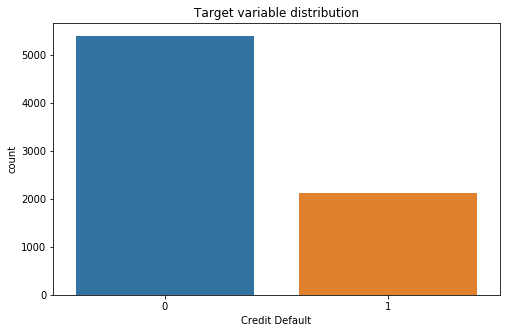

In [28]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

**Корреляция с базовыми признаками**

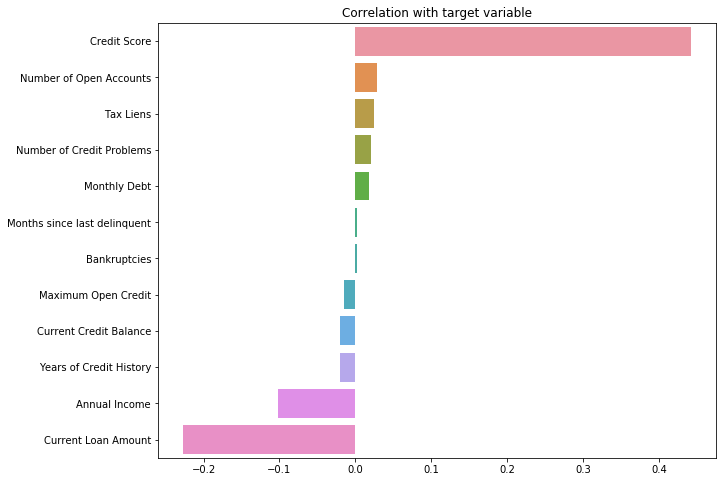

In [29]:
corr_with_target = df_base[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Анализ признакового пространства<a class="anchor" id="features_analysis"></a>

**Матрица корреляций**

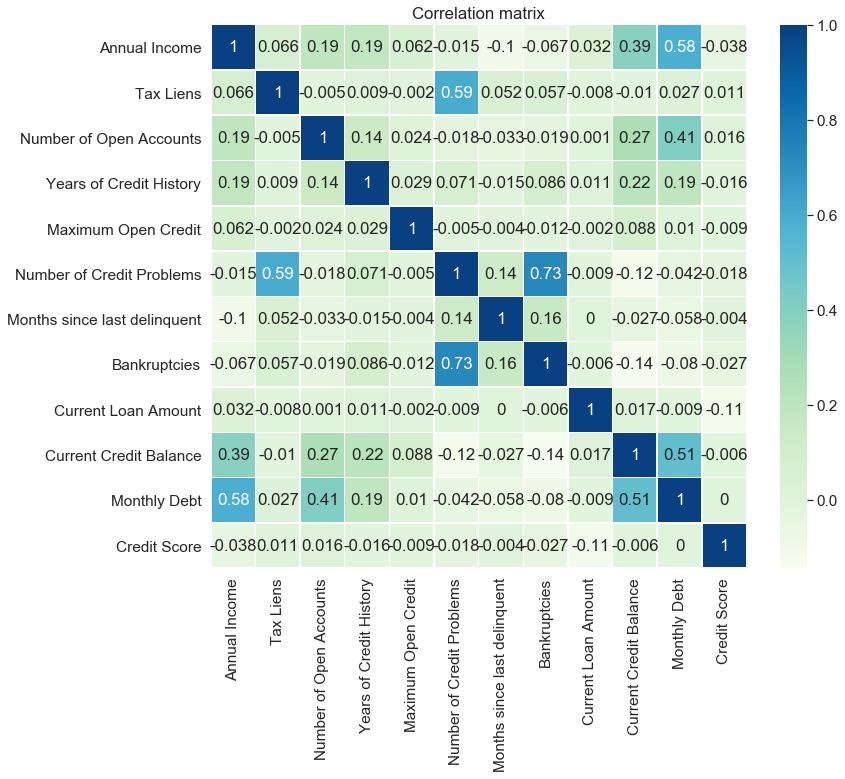

In [30]:
plt.figure(figsize = (12,10))

sns.set(font_scale=1.4)
sns.heatmap(df_base[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Сильной корреляции между признаками не прослеживается

**Теперь посмотрим на распределения всех интересующих нас количественных признаков**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D4B0EF0>,
      dtype=object)

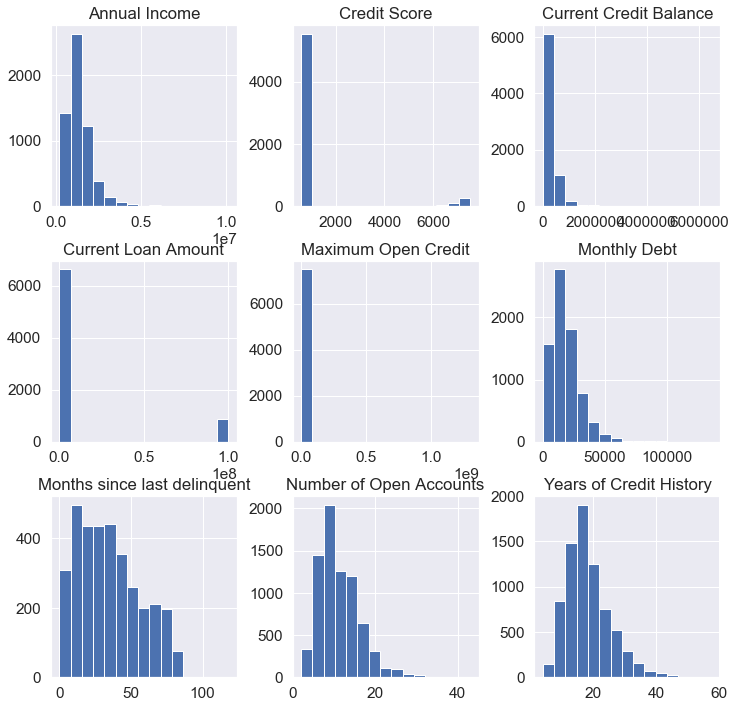

In [31]:
df_base[NUM_FEATURE_NAMES].hist(figsize=(12,12), bins=15)

Видим, что ни у одного из количественныхпризнаков распределение не близко к нормальному.

Графики большинства признаков больше напоминают распределение Пуассона.

### Полезные функции

In [32]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

### Приведение типов для модели CatBoost

In [33]:
def types_for_CatBoost(cat_features_name, df):
    for colname in cat_features_name:
        df[colname] = pd.Categorical(df[colname])
    return df

In [34]:
df_train = types_for_CatBoost(CAT_FEATURE_NAMES, df_train)
# df_base = types_for_CatBoost(CAT_FEATURE_NAMES, df)
df_train[CAT_FEATURE_NAMES].dtypes

Home Ownership               category
Years in current job         category
Tax Liens                    category
Number of Credit Problems    category
Bankruptcies                 category
Purpose                      category
Term                         category
dtype: object

### Нормализация данных<a class="anchor" id="normalization"></a>

In [35]:
scaler = StandardScaler()

df_norm = df_train.copy() # df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df_train = df_norm.copy()

**Сохранение модели для нормализации данных**

In [36]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [37]:
X = df_train[SELECTED_FEATURE_NAMES + CAT_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=21)

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [38]:
def balance_df_by_target(X,y):
    """данный метод проводит балансировку данных по целевой переменной"""    
    ros = RandomOverSampler(random_state=42)
    X_balanced, y_balanced = ros.fit_resample(X, y)
    
    print('Balanceed dataset %s' % Counter(y_balanced))
    return X_balanced, y_balanced

In [39]:
# Выполним балансировку данных по целевой переменной
X_train, y_train = balance_df_by_target(X,y)

Balanceed dataset Counter({0: 5387, 1: 5387})


### Сохранение обучающего и тестового датасетов<a class="anchor" id="train_test_saving"></a> 

In [40]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [41]:
df_train.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Построение и оценка базовой модели<a class="anchor" id="baseline_modeling"></a> 

*CatBoost*

In [42]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21, cat_features=CAT_FEATURE_NAMES)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      5387
           1       0.89      0.89      0.89      5387

    accuracy                           0.89     10774
   macro avg       0.89      0.89      0.89     10774
weighted avg       0.89      0.89      0.89     10774

TEST

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1616
           1       0.76      0.85      0.80       634

    accuracy                           0.88      2250
   macro avg       0.85      0.87      0.86      2250
weighted avg       0.89      0.88      0.89      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1450  166
1                 96  538


### Подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a> 

In [43]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21, cat_features=CAT_FEATURE_NAMES)

In [44]:
params = {'n_estimators':[50, 100, 200, 500, 750], 
          'max_depth':[3, 5, 7]}

In [45]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [46]:
#%%time

rs = GridSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)

In [47]:
rs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x000000000FDC6AC8>,
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200, 500, 750]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [48]:
rs.best_params_

{'max_depth': 7, 'n_estimators': 50}

In [49]:
rs.best_score_

0.4457284481235457

In [50]:
n_estimators = rs.best_params_['n_estimators']
max_depth = rs.best_params_['max_depth']

**Полезные функции**

In [51]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [52]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [53]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (10, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [54]:
final_model = catb.CatBoostClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                      silent=True, random_state=21, cat_features=CAT_FEATURE_NAMES)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      5387
           1       0.81      0.80      0.80      5387

    accuracy                           0.81     10774
   macro avg       0.81      0.81      0.81     10774
weighted avg       0.81      0.81      0.81     10774

TEST

              precision    recall  f1-score   support

           0       0.90      0.81      0.86      1616
           1       0.62      0.77      0.69       634

    accuracy                           0.80      2250
   macro avg       0.76      0.79      0.77      2250
weighted avg       0.82      0.80      0.81      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1317  299
1                145  489


### Снижение степени переобучения<a class="anchor" id="lowering_overfitting"></a>

In [55]:
final_model = catb.CatBoostClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21, cat_features=CAT_FEATURE_NAMES)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.67      0.75      0.71      5387
           1       0.72      0.63      0.67      5387

    accuracy                           0.69     10774
   macro avg       0.69      0.69      0.69     10774
weighted avg       0.69      0.69      0.69     10774

TEST

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1616
           1       0.49      0.62      0.55       634

    accuracy                           0.71      2250
   macro avg       0.66      0.68      0.67      2250
weighted avg       0.74      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1204  412
1                240  394


### Важность признаков<a class="anchor" id="feature_importances"></a>

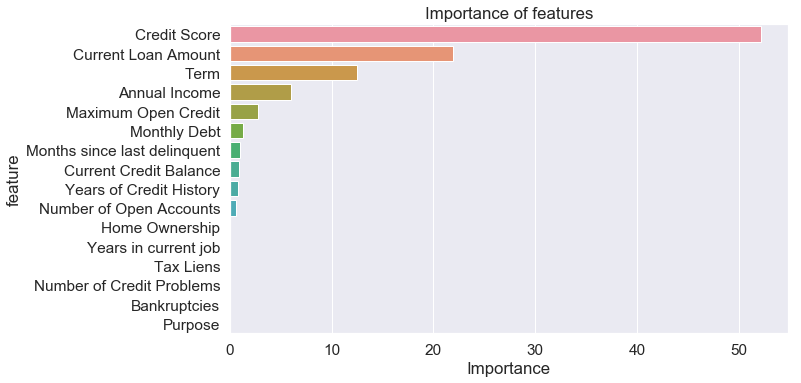

In [56]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=6)

Для финальной модели будем использовать 6 наиболее значимых признаков. Обоснование:
    
1. Более простая и хорошо настроенная модель лучше, чем сложная и плохо настроенная;

2. Это позволит снизить степень/вероятность переобучения;

3. Экспериметы показали, что 6 признаков дают результат лучше, чем любое другое количество.

In [57]:
important_features_top

['Credit Score',
 'Current Loan Amount',
 'Term',
 'Annual Income',
 'Maximum Open Credit',
 'Monthly Debt']

### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

In [58]:
final_model = catb.CatBoostClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                      silent=True, random_state=21, cat_features=CAT_FEATURE_NAMES)

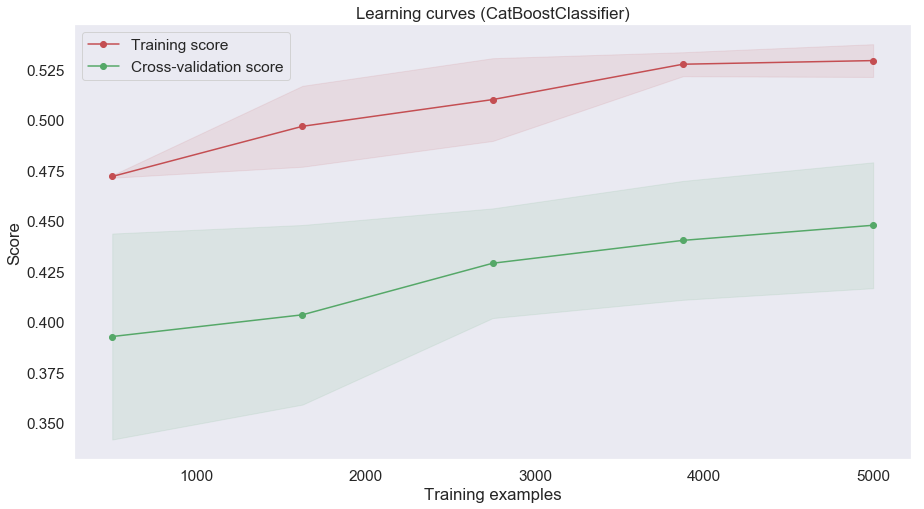

In [59]:
show_learning_curve_plot(final_model, X, y)

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

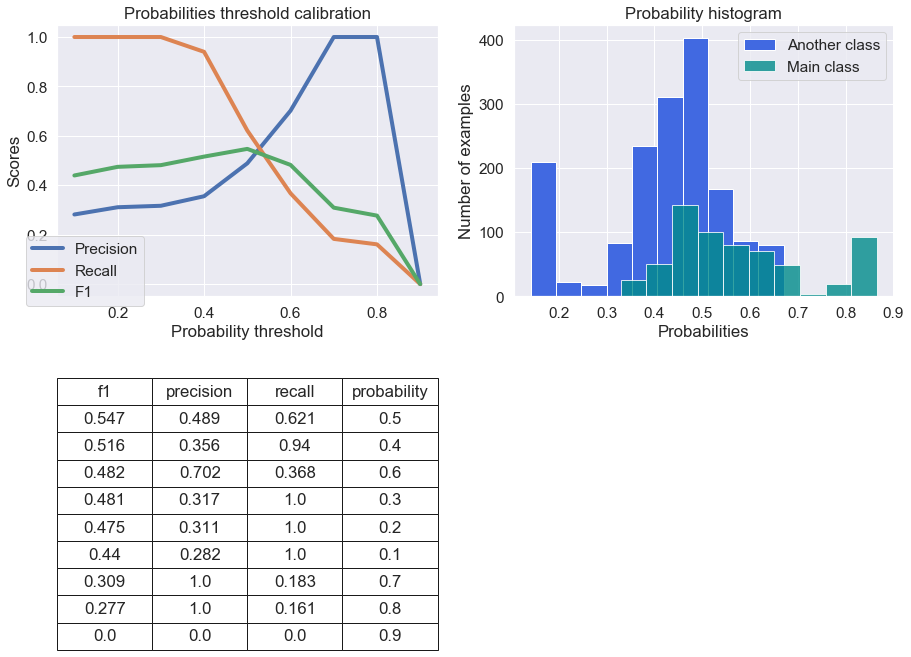

In [60]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Обучение и оценка финальной модели

In [61]:
new_cat_features_names = list(set(CAT_FEATURE_NAMES) & set(important_features_top))

In [62]:
final_model = catb.CatBoostClassifier(best_model_min_trees=35, 
                                      loss_function ='Logloss',
                                      od_wait=2,
                                      learning_rate=0.02,
                                      n_estimators=750, 
                                      max_depth=11, 
                                      l2_leaf_reg=95,
                                      silent=True, 
                                      random_state=162,
                                      cat_features=new_cat_features_names)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      5387
           1       0.82      0.81      0.82      5387

    accuracy                           0.82     10774
   macro avg       0.82      0.82      0.82     10774
weighted avg       0.82      0.82      0.82     10774

TEST

              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1616
           1       0.62      0.76      0.68       634

    accuracy                           0.80      2250
   macro avg       0.76      0.79      0.77      2250
weighted avg       0.82      0.80      0.80      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1319  297
1                155  479


### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [63]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

## Прогнозирование на тестовом датасете

### Выполнить для тестового датасета те же этапы обработки и построения признаков

Обработаем данные в тестовом датасете

In [64]:
df_test = convert_types(df_test)
df_test = process_Annual_Income(df_test)
df_test = process_objects_and_blanks(df_test)

Стандартизируем значения в df_test

In [65]:
scaler = StandardScaler()

df_norm = df_test.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df_test = df_norm.copy()

Приведение типов для модели CatBoost

In [66]:
df_test = types_for_CatBoost(CAT_FEATURE_NAMES, df_test)

### Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете.
### Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
### Соблюдать исходный порядок примеров из тестового датасета

In [67]:
df_test[TARGET_NAME] = final_model.predict(df_test[important_features_top])

### Сохранение результата обучения

In [68]:
#Сохраним результат в файл
df_test.loc[:, [TARGET_NAME]].to_csv('TSataev_predictions.csv', index=None)